In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import os

In [2]:
# Main Data Imports
game_summary = pd.read_parquet('Data/game_summary.parquet')

In [42]:
def extract_bans(games, team):
    team_blue = games[(games['team_1_name'] == team)]
    team_red = games[(games['team_2_name'] == team)]

    blue_bans = team_blue[[f'bb{i}' for i in range(1, 5+1)]]
    red_bans = team_red[[f'rb{i}' for i in range(1, 5+1)]]

    # extract overall
    blue_overall_vc = blue_bans.melt()['value'].value_counts()
    red_overall_vc =  red_bans.melt()['value'].value_counts()
    overall_vc = pd.concat([blue_overall_vc, red_overall_vc])

    # extract per side in order
    blue_bans_df = pd.DataFrame(columns=['ban', 'champion', 'count'])
    for column in blue_bans.columns:
        value_counts = blue_bans[column].value_counts().reset_index()
        value_counts.columns = ['champion', 'count']
        value_counts['ban'] = column
        blue_bans_df = pd.concat([blue_bans_df, value_counts])

    red_bans_df = pd.DataFrame(columns=['ban', 'champion', 'count'])
    for column in red_bans.columns:
        value_counts = red_bans[column].value_counts().reset_index()
        value_counts.columns = ['champion', 'count']
        value_counts['ban'] = column
        red_bans_df = pd.concat([red_bans_df, value_counts])
    return {'overall': overall_vc, 'blue': blue_bans_df, 'red': red_bans_df}

In [57]:
def extract_bans_two_teams(games: pd.DataFrame, team: str, enemy_team: str):
    team_dicts = extract_bans(games, team)

    # extract most recent 3 games
    games.sort_values('game_start_date_time', ascending=False)

    # extract team vs enemy team specific
    games_with_enemy = games[(games['team_1_name'] == team) & (games['team_2_name'] == enemy_team) 
                       | (games['team_1_name'] == enemy_team) & (games['team_2_name'] == team)]
    
    sorted_games = games_with_enemy.sort_values('game_start_date_time', ascending=False)
    
    team_dicts['with_enemy'] = {team: extract_bans(sorted_games, team), 
                                enemy_team: extract_bans(sorted_games, enemy_team)}

    return team_dicts

In [5]:
c9_games = game_summary[(game_summary['team_1_name'] == 'C9') | (game_summary['team_2_name'] == 'C9')]

In [9]:
c9_blue = c9_games[(c9_games['team_1_name'] == 'C9')]
c9_red = c9_games[(c9_games['team_2_name'] == 'C9')]

In [27]:
blue_picks = c9_blue[[f'bb{i}' for i in range(1, 5+1)]]
red_picks = c9_red[[f'rb{i}' for i in range(1, 5+1)]]

In [28]:
blue_ov_vc = c9_blue[[f'bb{i}' for i in range(1, 5+1)]].melt()['value'].value_counts()
red_ov_vc = c9_red[[f'bb{i}' for i in range(1, 5+1)]].melt()['value'].value_counts()

In [29]:
overall_vc = pd.concat([blue_ov_vc, red_ov_vc])

In [36]:
result_df = pd.DataFrame(columns=['ban', 'champion', 'count'])
for column in blue_picks.columns:
    value_counts = blue_picks[column].value_counts().reset_index()
    value_counts.columns = ['champion', 'count']
    value_counts['ban'] = column
    result_df = pd.concat([result_df, value_counts])
for column in red_picks.columns:
    value_counts = red_picks[column].value_counts().reset_index()
    value_counts.columns = ['champion', 'count']
    value_counts['ban'] = column
    result_df = pd.concat([result_df, value_counts])

In [37]:
result_df

,ban,champion,count
0,bb1,Blitzcrank,5
1,bb1,Xayah,5
2,bb1,Azir,3
3,bb1,Rakan,1
4,bb1,Sejuani,1
...,...,...,...
5,rb5,Renekton,1
6,rb5,Khazix,1
7,rb5,Xayah,1
8,rb5,Kindred,1


In [58]:
c9_bans = extract_bans_two_teams(c9_games, 'C9', 'GG')

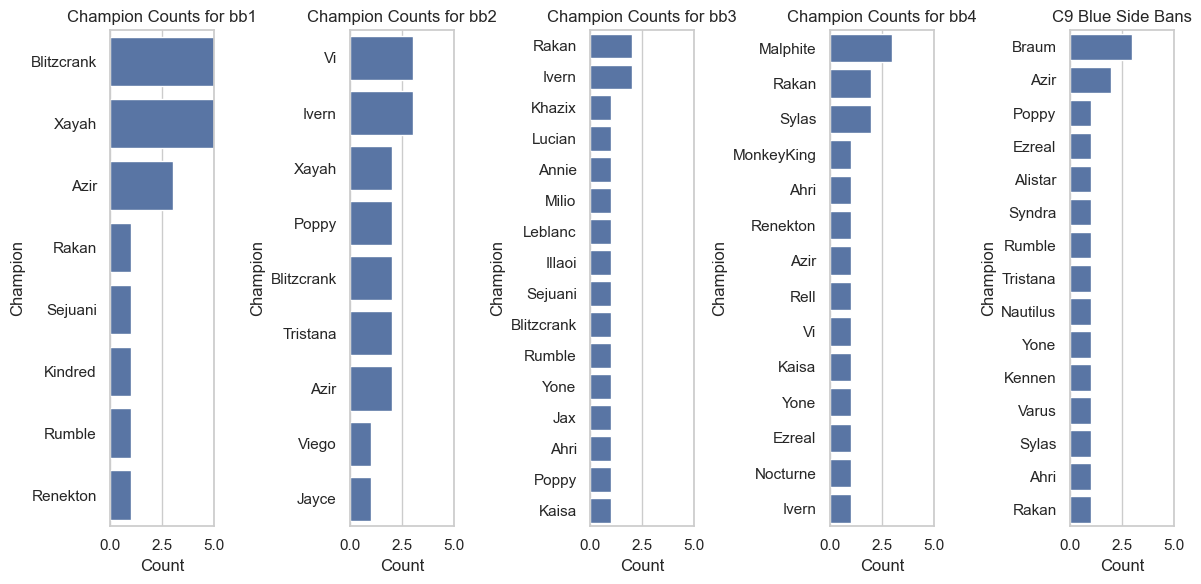

In [122]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = c9_bans['blue']['ban'].unique()
max_count = c9_bans['blue']['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = c9_bans['blue'][c9_bans['blue']['ban'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

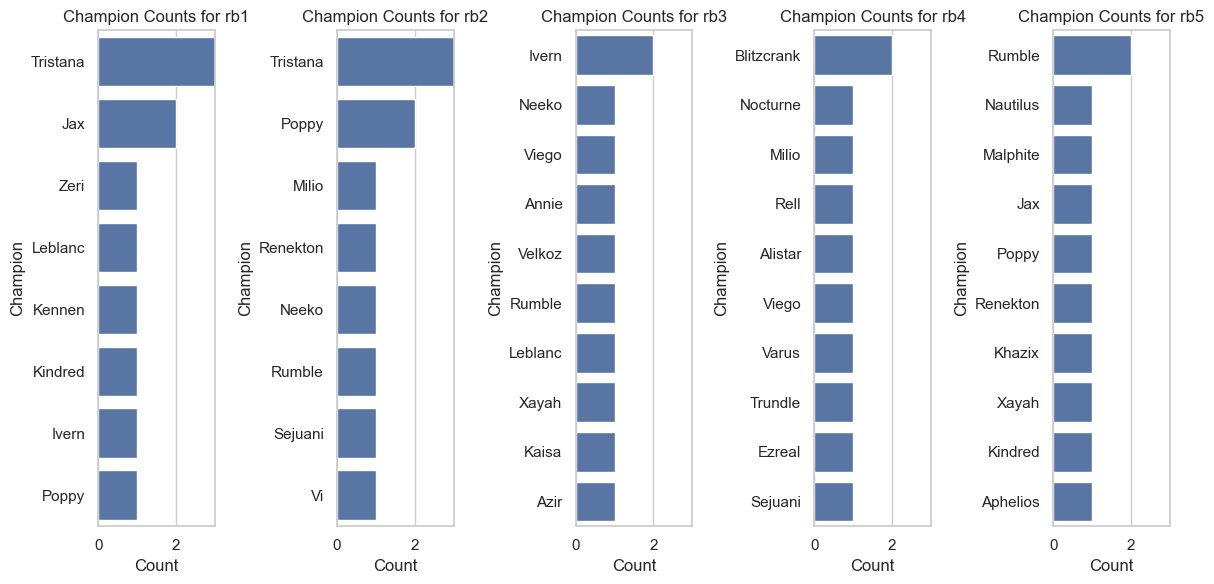

In [60]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = c9_bans['red']['ban'].unique()
max_count = c9_bans['red']['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = c9_bans['red'][c9_bans['red']['ban'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [69]:
bans_df = c9_bans['with_enemy']['GG']['blue']

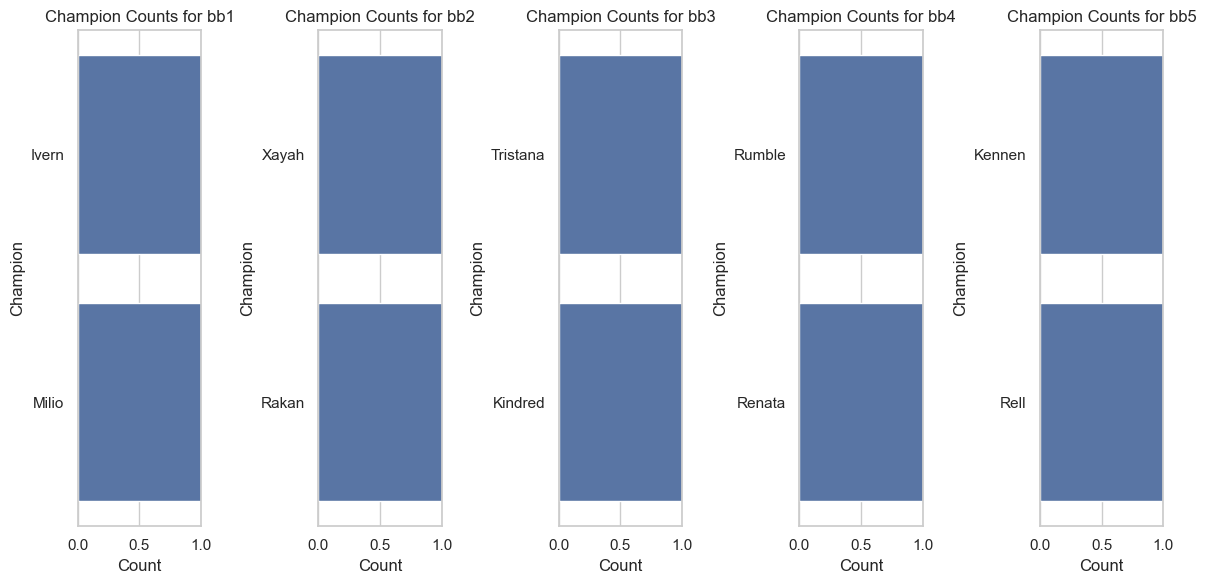

In [70]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = bans_df['ban'].unique()
max_count = bans_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = bans_df[bans_df['ban'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [123]:
bans_df = c9_bans['with_enemy']['GG']['red']

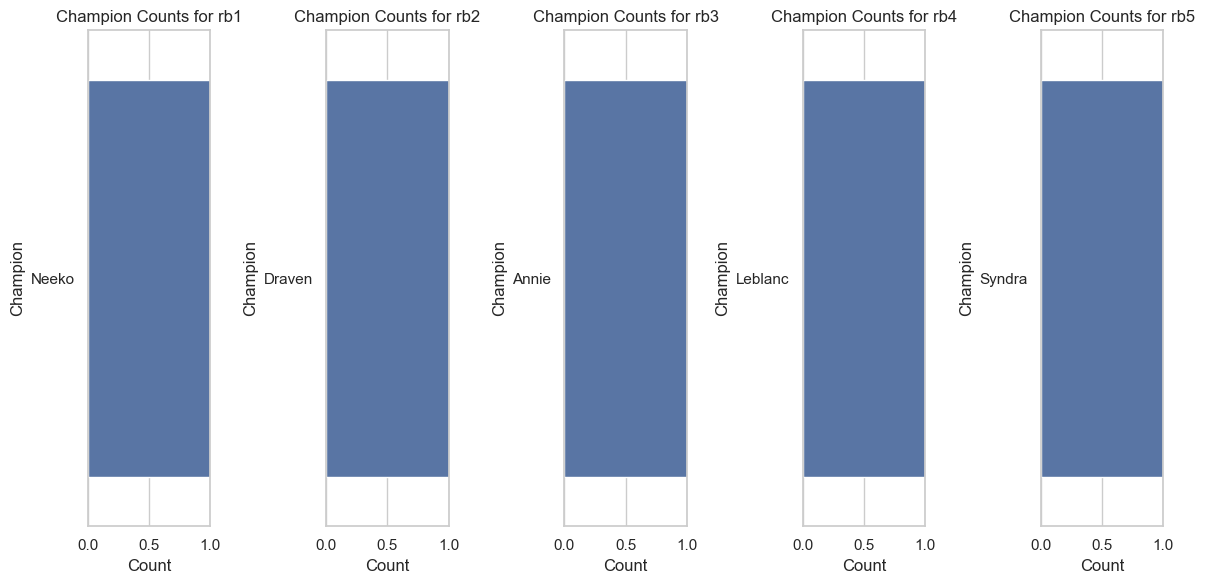

In [124]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = bans_df['ban'].unique()
max_count = bans_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = bans_df[bans_df['ban'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [99]:
def extract_picks(games, team):
    team_blue = games[(games['team_1_name'] == team)]
    team_red = games[(games['team_2_name'] == team)]

    blue_picks = team_blue[[f'bp{i}' for i in range(1, 5+1)]]
    red_picks = team_red[[f'rp{i}' for i in range(1, 5+1)]]

    # extract overall
    blue_overall_vc = blue_picks.melt()['value'].value_counts()
    red_overall_vc =  red_picks.melt()['value'].value_counts()
    overall_vc = pd.concat([blue_overall_vc, red_overall_vc])

    # extract per side in order
    blue_picks_df = pd.DataFrame(columns=['pick', 'champion', 'count'])
    for column in blue_picks.columns:
        value_counts = blue_picks[column].value_counts().reset_index()
        value_counts.columns = ['champion', 'count']
        value_counts['pick'] = column
        blue_picks_df = pd.concat([blue_picks_df, value_counts])

    red_picks_df = pd.DataFrame(columns=['pick', 'champion', 'count'])
    for column in red_picks.columns:
        value_counts = red_picks[column].value_counts().reset_index()
        value_counts.columns = ['champion', 'count']
        value_counts['pick'] = column
        red_picks_df = pd.concat([red_picks_df, value_counts])
    return {'overall': overall_vc, 'blue': blue_picks_df, 'red': red_picks_df}

In [100]:
def extract_picks_two_teams(games: pd.DataFrame, team: str, enemy_team: str):
    team_dicts = extract_picks(games, team)

    # extract most recent 3 games
    games.sort_values('game_start_date_time', ascending=False)

    # extract team vs enemy team specific
    games_with_enemy = games[(games['team_1_name'] == team) & (games['team_2_name'] == enemy_team) 
                       | (games['team_1_name'] == enemy_team) & (games['team_2_name'] == team)]
    
    sorted_games = games_with_enemy.sort_values('game_start_date_time', ascending=False)
    
    team_dicts['with_enemy'] = {team: extract_picks(sorted_games, team), 
                                enemy_team: extract_picks(sorted_games, enemy_team)}

    return team_dicts

In [101]:
c9_picks = extract_picks_two_teams(c9_games, 'C9', 'GG')

In [102]:
picks_df = c9_picks['blue']

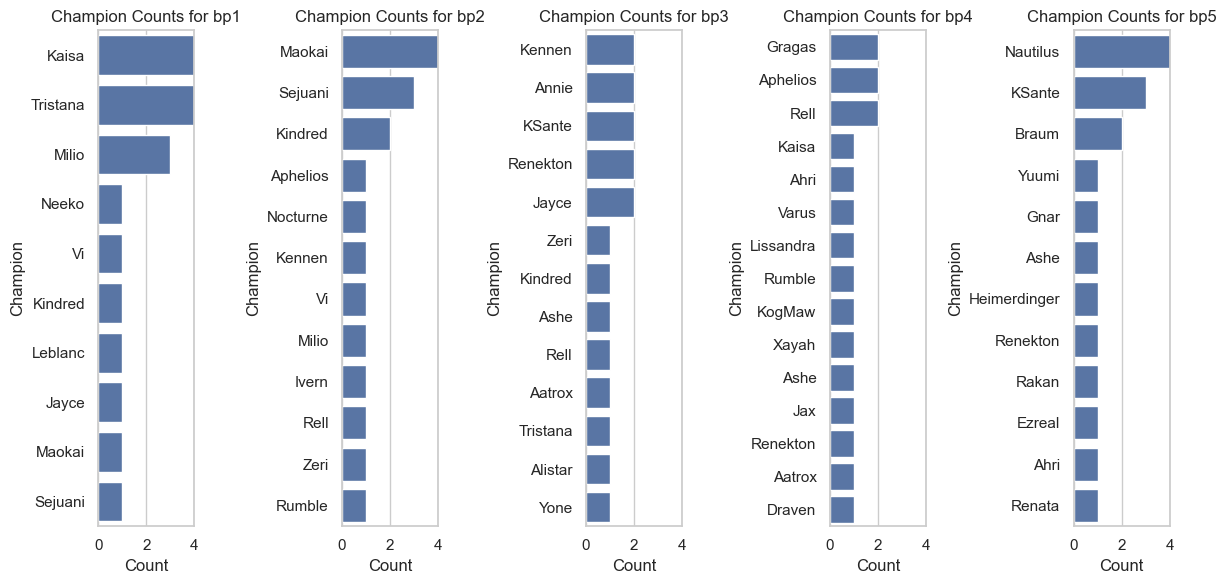

In [103]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = picks_df['pick'].unique()
max_count = picks_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = picks_df[picks_df['pick'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [104]:
picks_df = c9_picks['red']

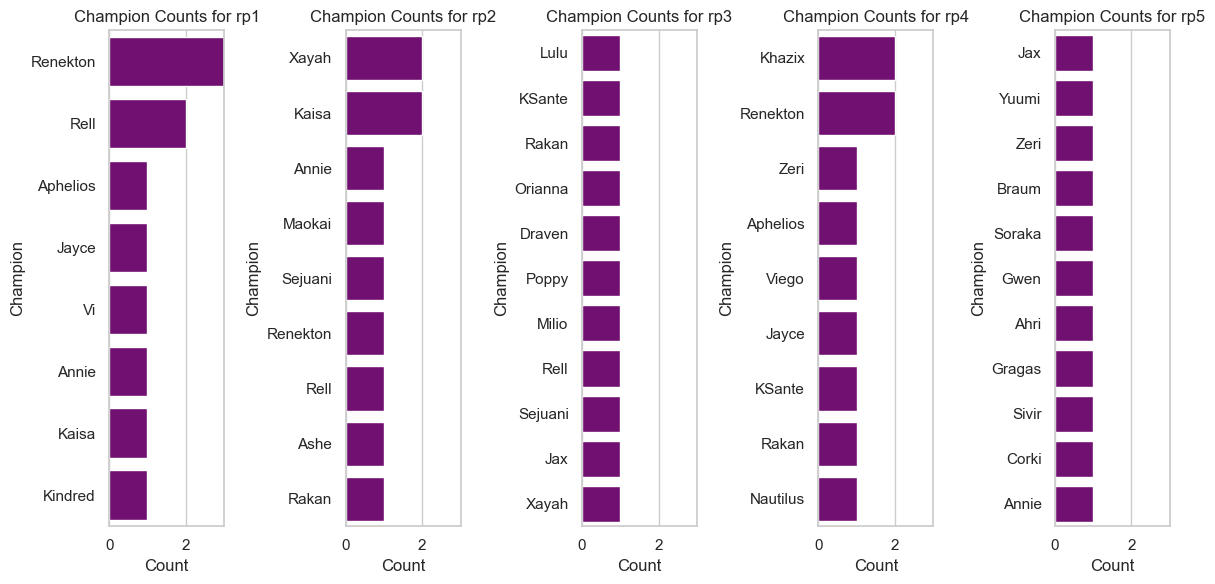

In [105]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = picks_df['pick'].unique()
max_count = picks_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = picks_df[picks_df['pick'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h", color='purple')
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [134]:
picks_df = c9_picks['with_enemy']['C9']['blue']

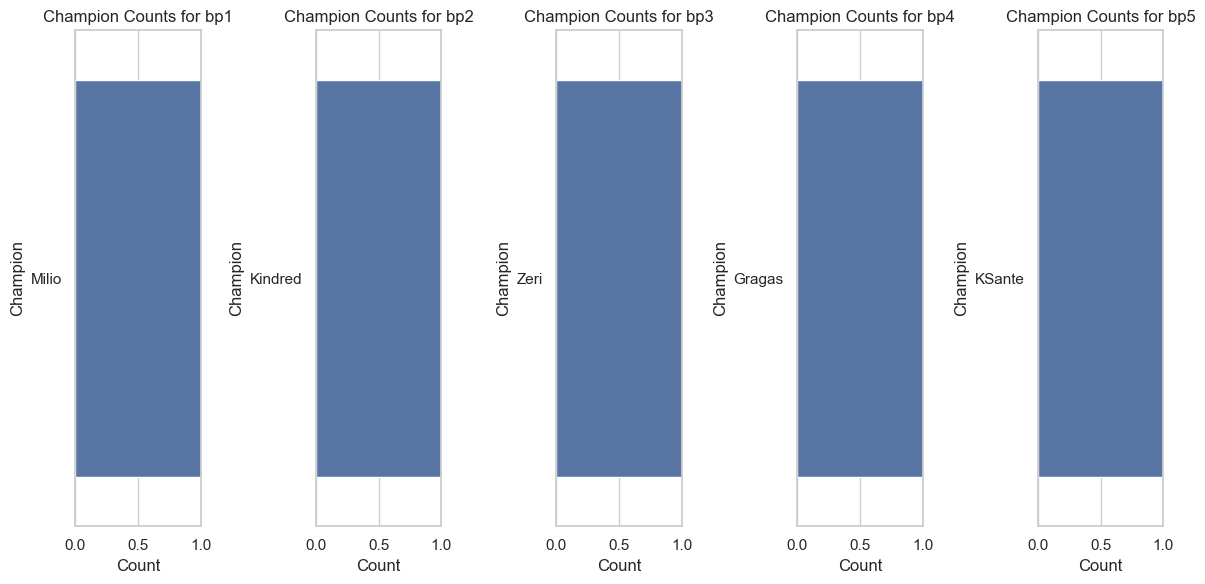

In [135]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = picks_df['pick'].unique()
max_count = picks_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = picks_df[picks_df['pick'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [140]:
picks_df = c9_picks['with_enemy']['GG']['red']

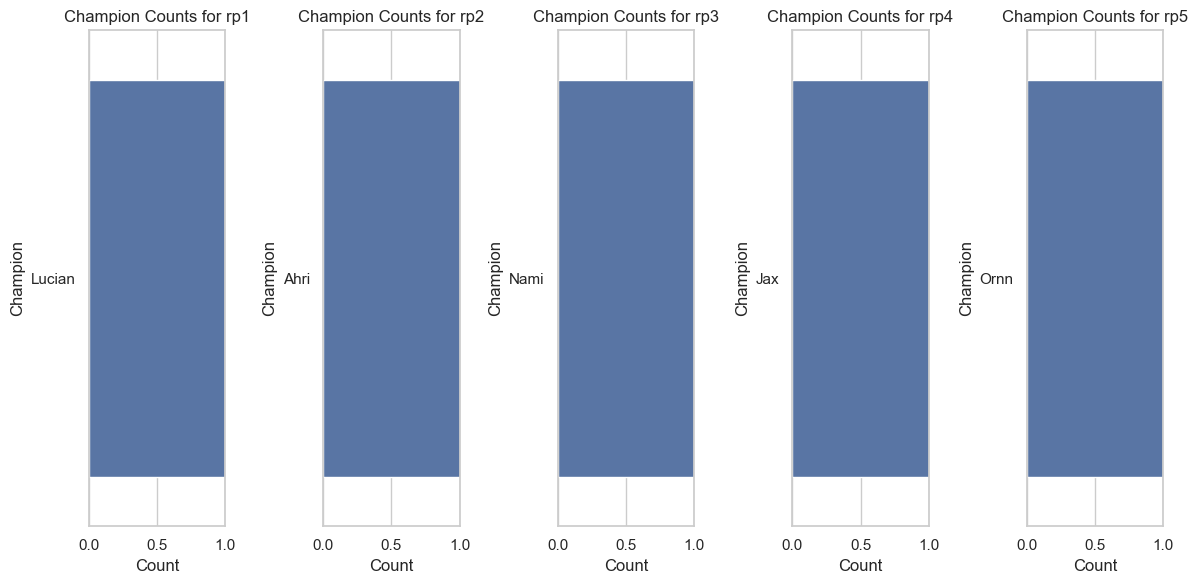

In [141]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = picks_df['pick'].unique()
max_count = picks_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = picks_df[picks_df['pick'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [136]:
picks_df = c9_picks['with_enemy']['C9']['red']

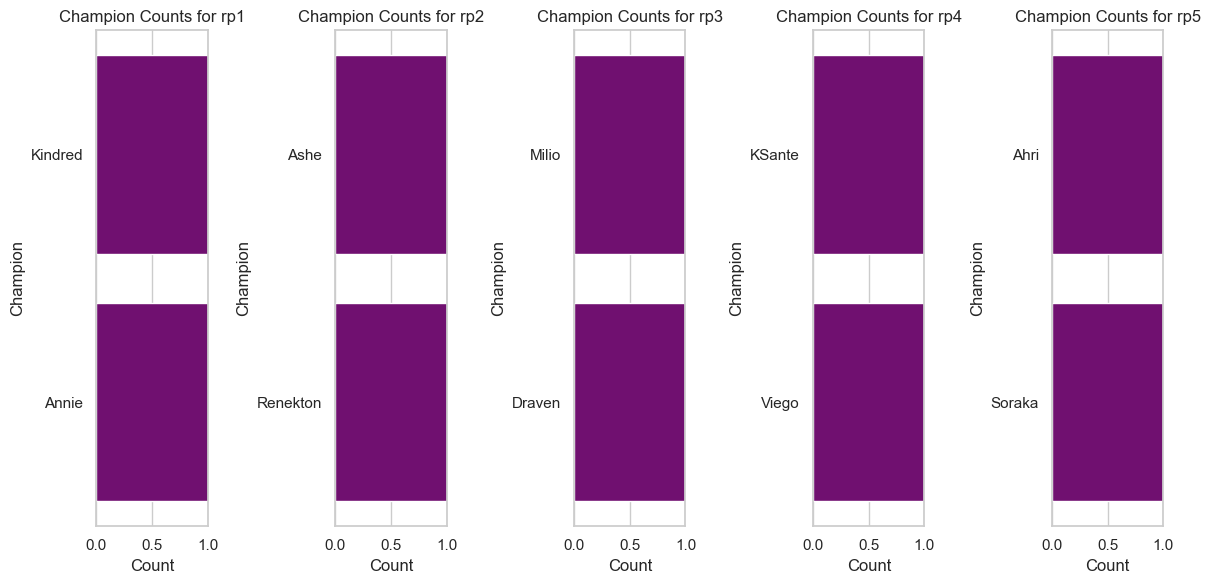

In [137]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = picks_df['pick'].unique()
max_count = picks_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = picks_df[picks_df['pick'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h", color='purple')
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

# GG Draft Focus

In [116]:
gg_games = game_summary[(game_summary['team_1_name'] == 'GG') | (game_summary['team_2_name'] == 'GG')]

In [117]:
gg_bans = extract_bans_two_teams(gg_games, 'GG', 'C9')
bans_df = gg_bans['blue']

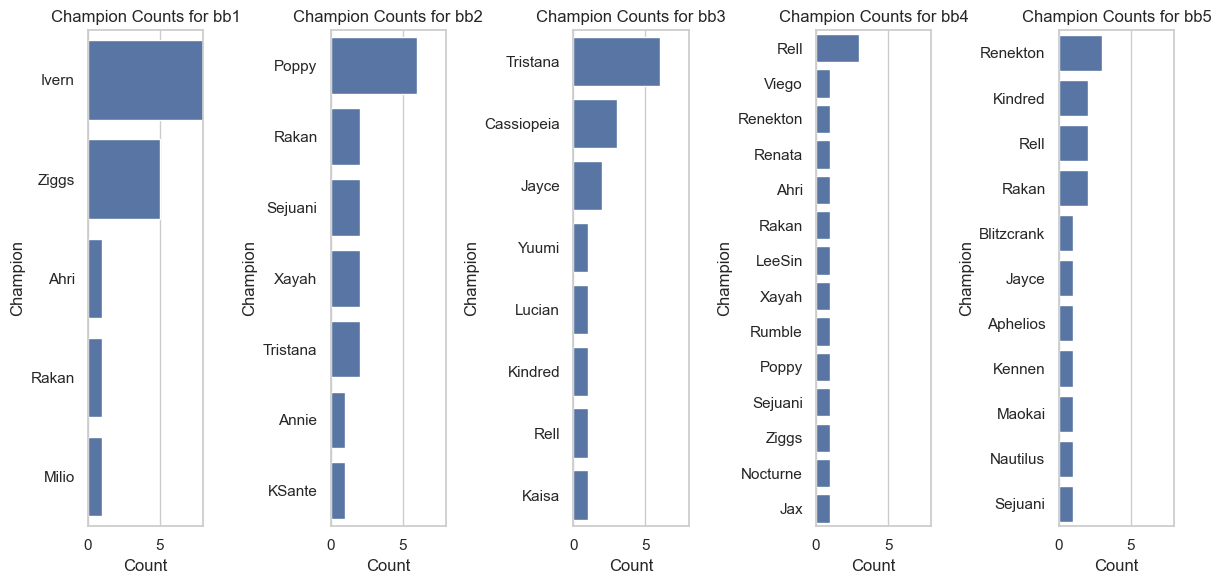

In [118]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = bans_df['ban'].unique()
max_count = bans_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = bans_df[bans_df['ban'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h")
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()

In [119]:
bans_df = gg_bans['red']

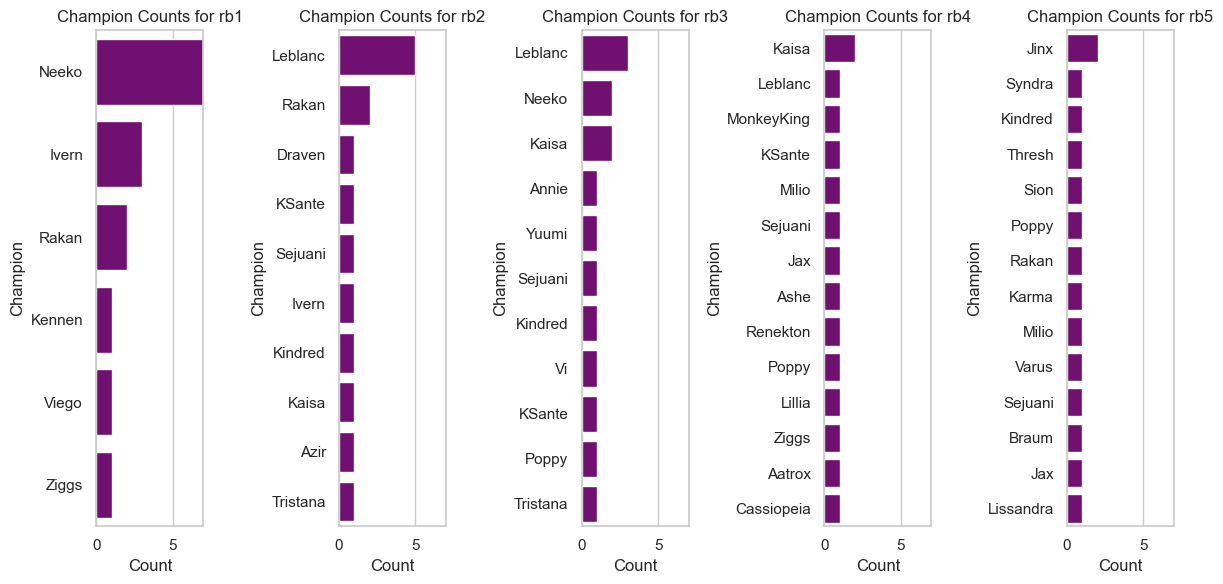

In [121]:
sns.set(style="whitegrid")
# Get unique 'ban' values
unique_picks = bans_df['ban'].unique()
max_count = bans_df['count'].max()

# Set up subplots for each 'ban' category
plt.figure(figsize=(12, 6))

for i, pick in enumerate(unique_picks):
    plt.subplot(1, len(unique_picks), i + 1)
    
    # Filter the DataFrame for the current 'ban' category
    sub_df = bans_df[bans_df['ban'] == pick]
    
    # Create a count plot for the current 'ban' category
    sns.barplot(x="count", y="champion", data=sub_df, orient="h", color='purple')
    
    # Set plot labels and title
    plt.xlim(0, max_count)
    plt.xlabel("Count")
    plt.ylabel("Champion")
    plt.title(f"Champion Counts for {pick}")
    
plt.tight_layout()
plt.show()